In [3]:
##############################
#### Basic Python Imports ####
##############################

import pandas as pd
import numpy as np
import pickle
import itertools
from collections import defaultdict

import warnings; warnings.simplefilter('ignore')

############################
#### Statsmodel Imports ####
############################
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller

##########################
#### Plotting Imports ####
##########################

import matplotlib.pyplot as plt
plt.style.use('ggplot') # Always make it pretty.
import plotly.graph_objects as go

# Import DataFrames

In [7]:
## File paths
train_pickle = 'pickled_files/train_data.pkl'
test_pickle = 'pickled_files/test_data.pkl'


In [8]:
## Read pickles in DataFrames
## Only include first column (cluster_1)
train = pd.read_pickle(train_pickle).iloc[:, 0:1]
test = pd.read_pickle(test_pickle).iloc[:, 0:1]

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2010-02-05 to 2012-04-06
Freq: W-FRI
Data columns (total 1 columns):
cluster_1    114 non-null float64
dtypes: float64(1)
memory usage: 1.8 KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 2012-04-13 to 2012-10-26
Freq: W-FRI
Data columns (total 1 columns):
cluster_1    29 non-null float64
dtypes: float64(1)
memory usage: 464.0 bytes


# Time Series Decomposition

## Additive Decomposition

In [11]:
train_add_decomposition = sm.tsa.seasonal_decompose(x=train, model='additive')

In [12]:
## Function to decompose time series data
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

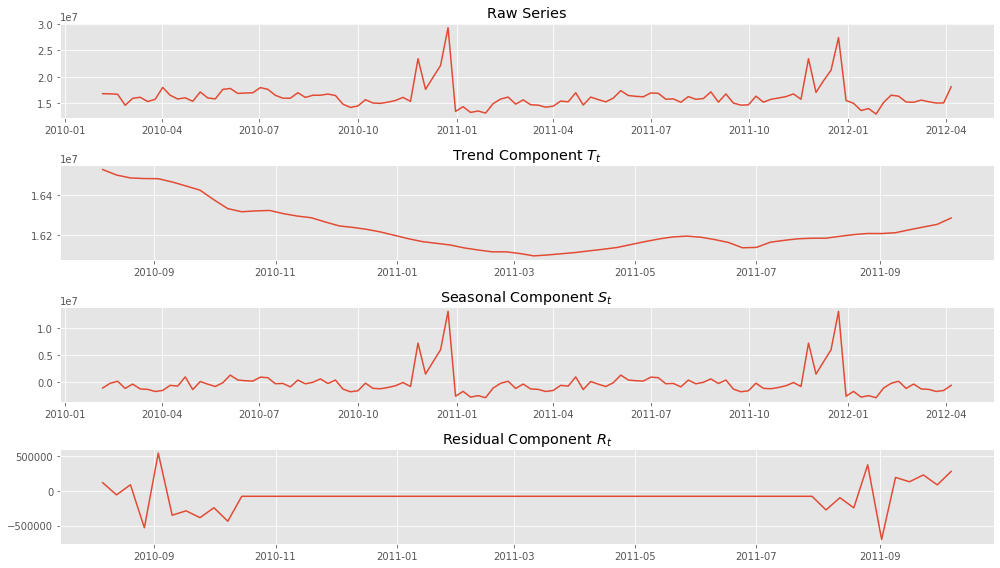

In [13]:
## Plot decomposed time series
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, train, train_add_decomposition)
plt.tight_layout()

# Time Series Stationarity

## Augmented Dickey-Fuller Test

In [14]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(train['cluster_1'].to_numpy(), regression='ct')

In [15]:
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -5.328869580513654
p-value: 4.9732357645652545e-05


The ADF test statistic of -5.32, with a p-value well below the significance level of 1%, allows us to reject the null hypothesis that the series is non-stationary, with a confidence level of 99%.

## Differencing

In [17]:
fig = go.Figure()
## Actual Sales
fig.add_trace(go.Scatter(x=train.index, y=train['cluster_1'],
    fill=None,
    name='Actuals',
    mode='lines',
    line_color='green',
    ))
## Update plot features
fig.update_layout(
    autosize=False,
    xaxis=go.layout.XAxis(title_text='Time Series'), 
    yaxis=go.layout.YAxis(title_text='Sales ($)'))

fig.show()

In [16]:
## Function to decompose time series data with a first order differencing
def plot_series_and_difference(axs, series, title):
    diff = series.diff().fillna(0)
    log_t = np.log(series)
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))
    axs[2].plot(series.index, log_t)
    axs[2].set_title("Log Transformed Series: {}".format(title))

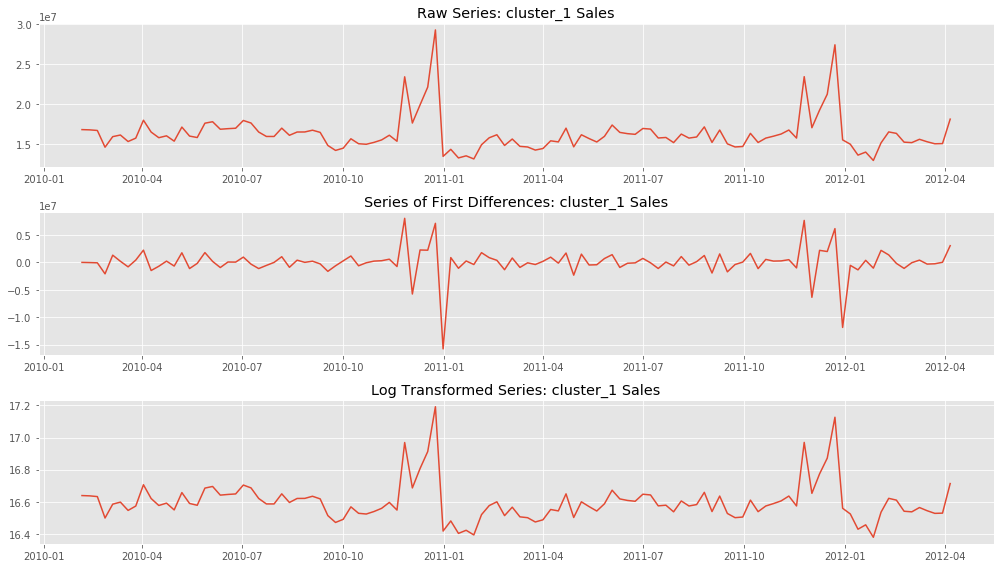

In [718]:
fig, axs = plt.subplots(3, figsize=(14, 8))
plot_series_and_difference(axs, train, 'cluster_1 Sales')
fig.tight_layout()

While the ADF test indiciated the raw series is stationary, it's worth noting the improved stationarity (visually) by completing a first order diference to the series.  

Modeling should be performed on both the Raw Series and the Series with First Differencing.

## Auto-Correlation

## Raw Series

### Auto-Correlation Function (ACF) Plot

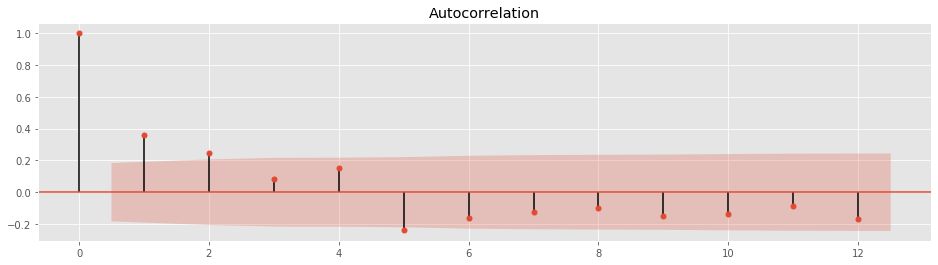

In [719]:
## Plot series Auto Correlation of lags
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(train, lags=12, ax=ax)

### Partial Auto-Correlation Function (PACF) Plot

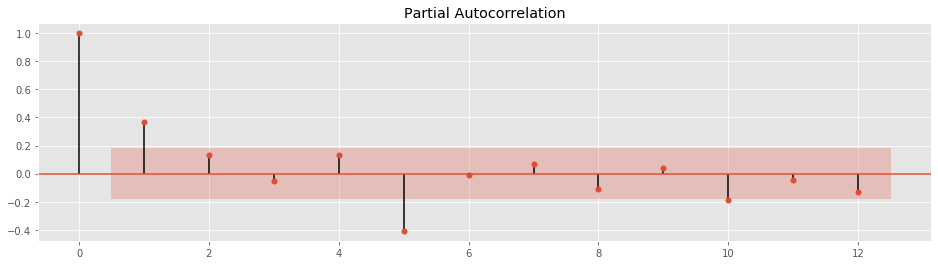

In [720]:
## Plot series Partial Auto Correlation of lags
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(train, lags=12, ax=ax)

## Differenced Series

### Auto-Correlation Function (ACF) Plot

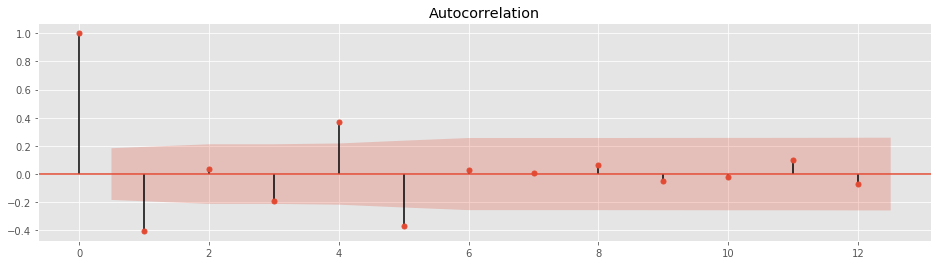

In [721]:
## Plot differnced series Auto Correlation of lags
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(train.diff().fillna(0), lags=12, ax=ax)

Based on the results of the ACF Plot — negative autocorrelation close to 0.5 at lag 1 — it is likley the series has been partially "overdifferenced". 

### Partial Auto-Correlation (PACF) Plot

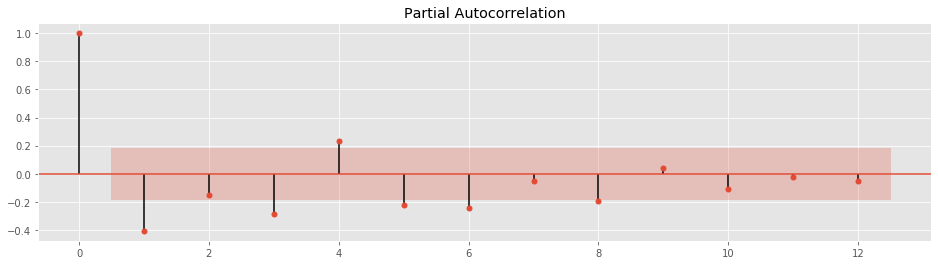

In [722]:
## Plot differenced series Partial Auto Correlation of lags
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(train.diff().fillna(0), lags=12, ax=ax)

# SARIMA Models

## Model #1
- Non-Seasonal differencing not required for model because ADF test already indicated stationarity. Differencing of one order would have likely resulted in "over-differencing" (noted by the large negative ACF and PACF in the first lag of the differenced series)


- One order of seasonal differencing implemented to remove the strong seasonality component of the series  


- AutoRegressive term = 1 based on one significant lag in the PACF plot  


- Moving Average term = 2 based on two significant lags in the ACF plot

In [723]:
model_1 = SARIMAX(np.log(train), order=(1,0, 2), seasonal_order=(0, 1, 0, 52)).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          cluster_1   No. Observations:                  114
Model:             SARIMAX(1, 0, 2)x(0, 1, 0, 52)   Log Likelihood                  96.847
Date:                            Mon, 09 Dec 2019   AIC                           -185.694
Time:                                    15:41:29   BIC                           -177.186
Sample:                                02-05-2010   HQIC                          -182.354
                                     - 04-06-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9775      0.041     23.719      0.000       0.897       1.058
ma.L1         -0.6737      0.158     -4.276      0.000      -0.982      -0.365
ma.L2         -0.1264      0.170     -0.742      0.458      -0.460       0.207
sigma2         0.0025      0.000      7.067      0.000       0.002       0.003
===================================================================================
Ljung-Box (Q):                       38.94   Jarque-Bera (JB):                14.60
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.06
Prob(H) (two-sided):                  0.90   Kurtosis:                         5.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model #2
- Non-Seasonal differencing not required for model because ADF test already indicated stationarity. Differencing of one order would have likely resulted in "over-differencing" (noted by the large negative ACF and PACF in the first lag of the differenced series)


- One order of seasonal differencing implemented to remove the strong seasonality component of the series  


- Reduced Moving Average term to 1; second lag's coefficient was not statistically significant based on it's p-value  


- Log Scaling performed on series to account for drastic spikes in seasonal trend
    - Substantially reduces AIC value

In [724]:
model_2 = SARIMAX(np.log(train), order=(1,0, 1), seasonal_order=(0, 1, 0, 52)).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          cluster_1   No. Observations:                  114
Model:             SARIMAX(1, 0, 1)x(0, 1, 0, 52)   Log Likelihood                  96.288
Date:                            Mon, 09 Dec 2019   AIC                           -186.576
Time:                                    15:41:30   BIC                           -180.195
Sample:                                02-05-2010   HQIC                          -184.071
                                     - 04-06-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9721      0.041     23.534      0.000       0.891       1.053
ma.L1         -0.7716      0.122     -6.304      0.000      -1.012      -0.532
sigma2         0.0026      0.000      7.429      0.000       0.002       0.003
===================================================================================
Ljung-Box (Q):                       40.02   Jarque-Bera (JB):                15.60
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.01
Prob(H) (two-sided):                  0.80   Kurtosis:                         5.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Compare Models
Look to optimize Mean Absolute Error (MAE) as a percentage of the average actual value. The reason for this is that Mean Absolute Percentage Error (MAPE):
- divides the error by the actual result at each time interval
- high errors during time intervals with low sales will have a major impact on MAPE
- optimizing MAPE will result in a forecast that will most likely undershoot the actual result  
    
Instead, examining the MAE as a percentage of the mean sales value will create a more stable model.

Grid search SARIMA model parameters that leads to optimal MAE % metric.  

Assess scores for each model for following time intervals:
- 1 period forward (1 week)
- 4 periods forward (1 month)
- 12 periods forward (3 months)
        

## Parameters to Search

In [725]:
## Non-Seasonal Parameters
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

pdq = list(itertools.product(p,d,q))

In [726]:
## Seasonal Parameters
sp = range(0, 2)
sd = range(0, 2)
sq = 0
season = 52

seasonal_pdq = [(x[0], x[1], sq, season) for x in list(itertools.product(sp,sd))]

## Grid Search Model Parameters

In [727]:
## Dictionary to store models' performance metrics
scores = {'model_params': [], 'aic': [], 'maep_1_week': [], 'maep_1_month': [], 'maep_3_months': [], 'maep_full': []}

for param in pdq:
    for s_param in seasonal_pdq:
        
        ## Fit SARIMAX model to training data (log transformed)
        model = SARIMAX(np.log(train), order=param, seasonal_order=s_param).fit()
        
        ## Four sets of predictions (for different time intervals)
        preds1 = np.exp(model.predict(start=test.index[0], end=test.index[0], dynamic=True, plot_insample=False))
        preds2 = np.exp(model.predict(start=test.index[0], end=test.index[3], dynamic=True, plot_insample=False))
        preds3 = np.exp(model.predict(start=test.index[0], end=test.index[11], dynamic=True, plot_insample=False))
        preds4 = np.exp(model.predict(start=test.index[0], end=test.index[-1], dynamic=True, plot_insample=False))
        
        maep1 = np.mean(abs(test['cluster_1'][0] - preds1)) / np.mean(test['cluster_1'][0])
        maep2 = np.mean(abs(test['cluster_1'][0:4] - preds2)) / np.mean(test['cluster_1'][0:4])
        maep3 = np.mean(abs(test['cluster_1'][0:12] - preds3)) / np.mean(test['cluster_1'][0:12]) 
        maep4 = np.mean(abs(test['cluster_1'] - preds4)) / np.mean(test['cluster_1'])
        
        scores['model_params'].append((param, s_param))
        scores['aic'].append(model.aic)
        scores['maep_1_week'].append(maep1)
        scores['maep_1_month'].append(maep2)
        scores['maep_3_months'].append(maep3)
        scores['maep_full'].append(maep4)
        
        #print(f'SARIMAX: {(param, s_param)} with MAE % score of {maep}')

In [728]:
scores_df = pd.DataFrame(scores)
scores_df.sort_values(by='maep_full', ascending=True, inplace=True)
scores_df.head()

model_params         aic  maep_1_week  maep_1_month  \
3   ((0, 0, 0), (1, 1, 0, 52)) -172.339088     0.012355      0.035200   
31  ((1, 0, 1), (1, 1, 0, 52)) -185.044363     0.043411      0.069032   
35  ((1, 0, 2), (1, 1, 0, 52)) -183.871570     0.058589      0.073059   
55  ((2, 0, 1), (1, 1, 0, 52)) -184.018932     0.062857      0.076151   
7   ((0, 0, 1), (1, 1, 0, 52)) -177.011511     0.054973      0.045606   

    maep_3_months  maep_full  
3        0.028632   0.027801  
31       0.036640   0.027861  
35       0.038240   0.028905  
55       0.039611   0.029799  
7        0.034159   0.029994

## Best Model

Proceeding with model # 3:
- **Non-Seasonal Parameters:** p = 0, d = 0, q = 0
- **Seasonal Parameters:** p = 1, d = 1, q = 0, season = 52  

This model provides the second lowest AIC and performs the most consistently in minimizing Mean Absolute Error % across several timeframes: predictions 1 week, 1 month, 3 months and 7 months (full test timeframe).

In [729]:
final_params = scores_df['model_params'][3]
best_model = SARIMAX(np.log(train), order=final_params[0], seasonal_order=final_params[1]).fit()

# SARIMA Predictions

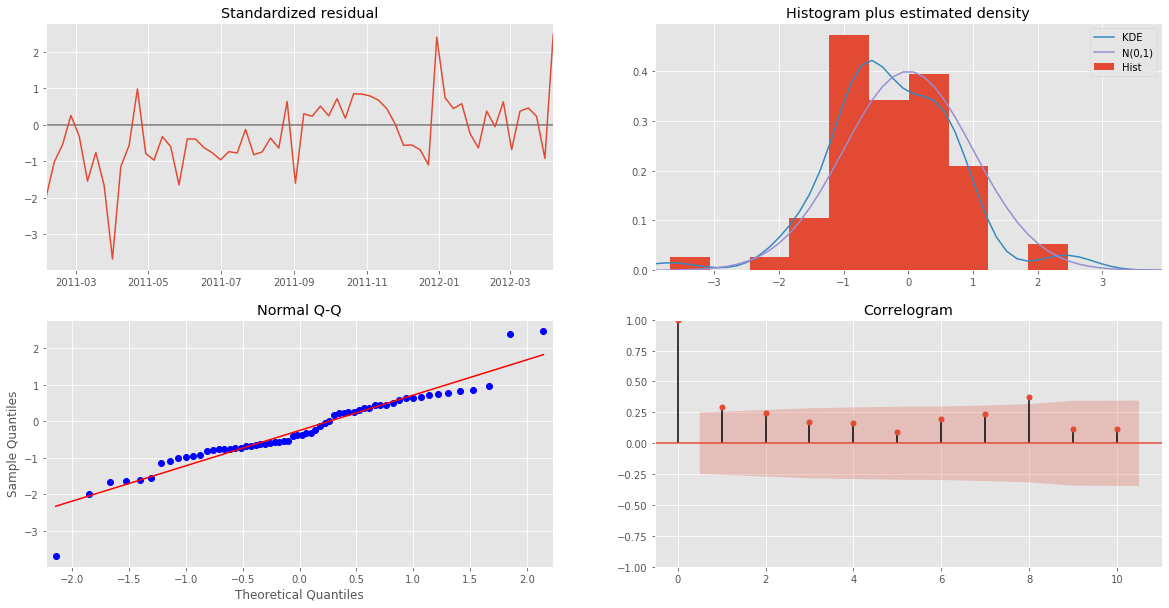

In [730]:
best_model.plot_diagnostics(figsize=(20, 10));

## Predictions w/ Confidence Interval

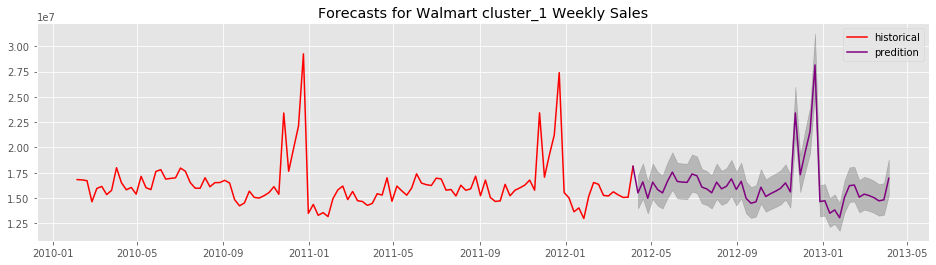

In [731]:
## Plot training data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(train.index, train, label='historical', color='red')

## Plot predictions (on test data)
preds = np.exp(best_model.predict(start=test.index[0], end=test.index[0] + 51, dynamic=True, ax=ax, plot_insample=False))
ax.plot(preds.index.insert(0, train.index[-1]), np.insert(preds.values, 0, train['cluster_1'][-1]), label='predition', color='purple')

## Plot 95% confidence interval for predictions
pred_ci = np.exp(best_model.get_forecast(52).conf_int(alpha=0.05))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title("Forecasts for Walmart cluster_1 Weekly Sales")
ax.legend();

## Predictions vs. Results

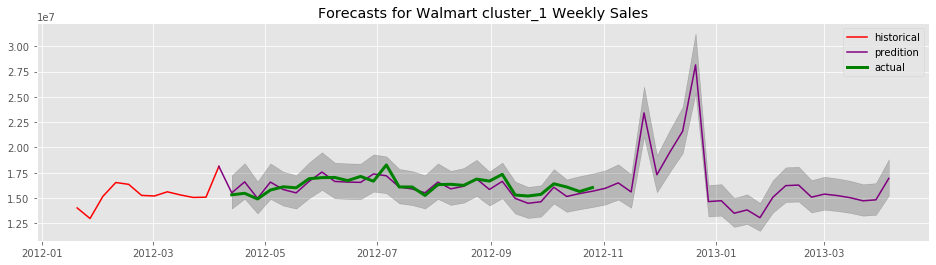

In [732]:
## Plot training data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(train.index[102:], train[102:], label='historical', color='red')

## Plot predictions (on test data)
preds = np.exp(best_model.predict(start=test.index[0], end=test.index[0] + 51, dynamic=True, ax=ax, plot_insample=False))
ax.plot(preds.index.insert(0, train.index[-1]), np.insert(preds.values, 0, train['cluster_1'][-1]), label='predition', color='purple')

## Plot 95% confidence interval for predictions
pred_ci = np.exp(best_model.get_forecast(52).conf_int(alpha=0.05))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.plot(test.index, test, label='actual', linestyle='-', lw=3.0, color='green')
ax.set_title("Forecasts for Walmart cluster_1 Weekly Sales")
ax.legend();

# Cluster_1 Model (Weekly) w/ Exogenous

## Import Field(s)

In [733]:
## File paths
train_holiday_pickle = 'pickled_files/train_holidays.pkl'
test_holiday_pickle = 'pickled_files/test_holidays.pkl'


In [734]:
## Read pickles in DataFrames
## Only include first column (cluster_1)
train_holiday = pd.DataFrame(pd.read_pickle(train_holiday_pickle).iloc[:, -1])
test_holiday = pd.DataFrame(pd.read_pickle(test_holiday_pickle).iloc[:, -1])

### Future Holidays Flags
To make predictions beyond the test data timeframe, values for "IsHoliday" dummy variable are required for time range beyond `test_holiday.index.max()`.

In [735]:
future_holidays_data = 'data_files/walmart-recruiting-store-sales-forecasting/test.csv'
future_holidays = pd.read_csv(future_holidays_data)

In [736]:
future_holidays.drop(columns=['Store', 'Dept'], inplace=True)
holiday_map = {True:1, False:0}
future_holidays['IsHoliday'] = future_holidays['IsHoliday'].map(holiday_map)
future_holidays.drop_duplicates(inplace=True)

In [737]:
future_holidays.set_index('Date', inplace=True)
future_holidays.index = pd.to_datetime(future_holidays.index)

In [738]:
future_holidays = future_holidays.asfreq('W-Fri', fill_value=0)

In [739]:
test_plus_future_holidays = pd.concat([test_holiday, future_holidays])

## SARIMAX - Optimizing MAE %

### Grid Search Model Parameters

In [740]:
best_model_exog = SARIMAX(np.log(train), order=final_params[0], 
                          seasonal_order=final_params[1], exog=train_holiday).fit()

In [741]:
## Four sets of predictions (for different time intervals)
preds1 = np.exp(best_model_exog.predict(start=test.index[0], end=test.index[0], 
                                        exog=test_holiday[0:1], dynamic=True, plot_insample=False))
preds2 = np.exp(best_model_exog.predict(start=test.index[0], end=test.index[3],  
                                        exog=test_holiday[0:4], dynamic=True, plot_insample=False))
preds3 = np.exp(best_model_exog.predict(start=test.index[0], end=test.index[11], 
                                        exog=test_holiday[0:12], dynamic=True, plot_insample=False))
preds4 = np.exp(best_model_exog.predict(start=test.index[0], end=test.index[-1],
                                        exog=test_holiday, dynamic=True, plot_insample=False))

maep1 = np.mean(abs(test['cluster_1'][0] - preds1)) / np.mean(test['cluster_1'][0])
maep2 = np.mean(abs(test['cluster_1'][0:4] - preds2)) / np.mean(test['cluster_1'][0:4])
maep3 = np.mean(abs(test['cluster_1'][0:12] - preds3)) / np.mean(test['cluster_1'][0:12]) 
maep4 = np.mean(abs(test['cluster_1'] - preds4)) / np.mean(test['cluster_1'])

In [742]:
print(f'Model Parameters: {final_params}.')
print(f'Model AIC: {model.aic}.')
print(f'MAE % - 1 Week Forecast: {maep1}.')
print(f'MAE % - 1 Month Forecast: {maep2}.')
print(f'MAE % - 3 Months Forecast: {maep3}.')
print(f'MAE % - 7 Months Forecast: {maep4}.')

Model Parameters: ((0, 0, 0), (1, 1, 0, 52)).
Model AIC: -178.75496279424078.
MAE % - 1 Week Forecast: 0.012355446172893152.
MAE % - 1 Month Forecast: 0.03519953031178755.
MAE % - 3 Months Forecast: 0.028631870441909013.
MAE % - 7 Months Forecast: 0.027800627827351748.


In [743]:
top_scores = scores_df[0:1]

top_scores.append(ignore_index=True, other={'model_params': [final_params, 'inc. exog'], 
                   'aic': model.aic,
                   'maep_1_week': maep1,
                   'maep_1_month': maep2,
                   'maep_3_months': maep3,
                   'maep_full': maep4})

model_params         aic  maep_1_week  \
0               ((0, 0, 0), (1, 1, 0, 52)) -172.339088     0.012355   
1  [((0, 0, 0), (1, 1, 0, 52)), inc. exog] -178.754963     0.012355   

   maep_1_month  maep_3_months  maep_full  
0        0.0352       0.028632   0.027801  
1        0.0352       0.028632   0.027801

### Predictions w/ Confidence Interval

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[1, 2, 3, 4], y=[3, 4, 8, 3],
    fill=None,
    mode='lines',
    line_color='indigo',
    ))
fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4],
    y=[1, 6, 2, 6],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='indigo'))

fig.show()

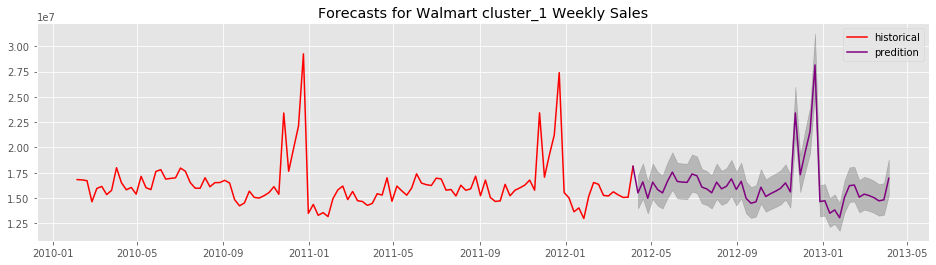

In [744]:
## Plot training data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(train.index, train, label='historical', color='red')

## Determine the number of future predictions to make
steps = 51

## Plot predictions (on test data)
preds = np.exp(best_model_exog.predict(start=test.index[0], end=test.index[0] + steps, 
                                       exog=test_plus_future_holidays[:steps+1], 
                                       dynamic=True, ax=ax, plot_insample=False))
ax.plot(preds.index.insert(0, train.index[-1]), 
        np.insert(preds.values, 0, train['cluster_1'][-1]), label='predition', color='purple')

## Plot 95% confidence interval for predictions
pred_ci = np.exp(best_model_exog.get_forecast(steps=steps+1, exog=test_plus_future_holidays[:steps+1])\
                                .conf_int(alpha=0.05))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title("Forecasts for Walmart cluster_1 Weekly Sales")
ax.legend();

### Predictions vs. Results

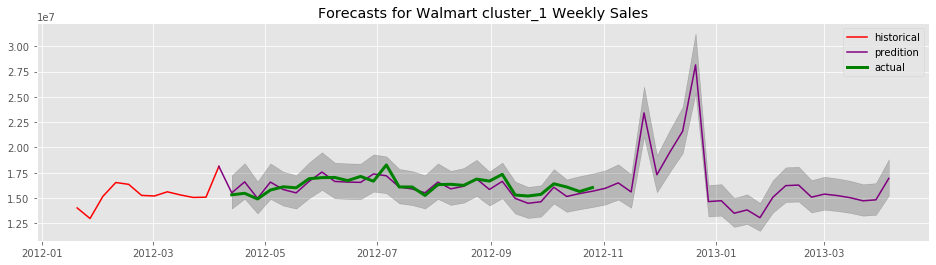

In [745]:
## Plot training data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(train.index[102:], train[102:], label='historical', color='red')

## Determine the number of future predictions to make
steps = 51

## Plot predictions (on test data)
preds = np.exp(best_model.predict(start=test.index[0], end=test.index[0] + steps, 
                                  exog=test_plus_future_holidays[:steps+1],
                                  dynamic=True, ax=ax, plot_insample=False))
ax.plot(preds.index.insert(0, train.index[-1]), 
        np.insert(preds.values, 0, train['cluster_1'][-1]), label='predition', color='purple')

## Plot 95% confidence interval for predictions
pred_ci = np.exp(best_model_exog.get_forecast(steps=steps+1, exog=test_plus_future_holidays[:steps+1])\
                                .conf_int(alpha=0.05))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.plot(test.index, test, label='actual', linestyle='-', lw=3.0, color='green')
ax.set_title("Forecasts for Walmart cluster_1 Weekly Sales")
ax.legend();

## SARIMAX - Optimizing MAPE
    Attempt grid search of SARIMAX parameters to optimize MAPE. See how this affects the prediction plot.

### Grid Search Model Parameters

In [775]:
## Dictionary to store models' performance metrics
scores3 = {'model_params': [], 'aic': [], 'mape_1_week': [], 'mape_1_month': [], 'mape_3_months': [], 'mape_full': []}

for param in pdq:
    for s_param in seasonal_pdq:
        
        ## Fit SARIMAX model to training data (log transformed)
        try:
            model = SARIMAX(np.log(train), order=param, 
                            seasonal_order=s_param, exog=train_holiday).fit()
        except:
            continue
        
        ## Four sets of predictions (for different time intervals)
        preds1 = np.exp(model.predict(start=test.index[0], end=test.index[0], 
                                      exog=test_holiday[0:1],
                                      dynamic=True, plot_insample=False))
        preds2 = np.exp(model.predict(start=test.index[0], end=test.index[3], 
                                      exog=test_holiday[0:4],
                                      dynamic=True, plot_insample=False))
        preds3 = np.exp(model.predict(start=test.index[0], end=test.index[11], 
                                      exog=test_holiday[0:12],
                                      dynamic=True, plot_insample=False))
        preds4 = np.exp(model.predict(start=test.index[0], end=test.index[-1], 
                                      exog=test_holiday,
                                      dynamic=True, plot_insample=False))
        
        mape1 = np.mean(abs(test['cluster_1'][0] - preds1) / abs(test['cluster_1'][0]))
        mape2 = np.mean(abs(test['cluster_1'][0:4] - preds2) / abs(test['cluster_1'][0:4]))
        mape3 = np.mean(abs(test['cluster_1'][0:12] - preds3) / abs(test['cluster_1'][0:12])) 
        mape4 = np.mean(abs(test['cluster_1'] - preds4) / abs(test['cluster_1']))
        
        scores3['model_params'].append((param, s_param))
        scores3['aic'].append(model.aic)
        scores3['mape_1_week'].append(mape1)
        scores3['mape_1_month'].append(mape2)
        scores3['mape_3_months'].append(mape3)
        scores3['mape_full'].append(mape4)
    

In [776]:
scores3_df = pd.DataFrame(scores3)
scores3_df.sort_values(by='mape_full', ascending=True, inplace=True)
scores3_df.head()

model_params         aic  mape_1_week  mape_1_month  \
3   ((0, 0, 0), (1, 1, 0, 52)) -170.339088     0.012355      0.034786   
57  ((2, 0, 2), (1, 1, 0, 52)) -179.150535     0.037713      0.067191   
30  ((1, 0, 1), (1, 1, 0, 52)) -183.044380     0.043460      0.068682   
33  ((1, 0, 2), (1, 1, 0, 52)) -181.884038     0.059817      0.073688   
7   ((0, 0, 1), (1, 1, 0, 52)) -175.011511     0.054980      0.045271   

    mape_3_months  mape_full  
3        0.028652   0.027690  
57       0.036926   0.028008  
30       0.037345   0.028026  
33       0.039570   0.029512  
7        0.034330   0.029857

No change in selection of top performing model when utlizing Mean Absolute Percentage Error as the metric to minimize.

# Cluster_1 Model (Monthly)

## Re-sample Data to Monthly

In [746]:
## Sales Data
monthly_data = pd.concat([train, test])
monthly_data = monthly_data.resample('M').sum()

## Determine how many unique months captures 80% of time series
month_count = int(len(monthly_data.index.unique())*0.8)

## Determine value of max month for training data set
max_test_month = monthly_data.index.unique()[month_count]

## Train & Test Split (based on date for 80% threshold of data/ rows)
train_monthly = monthly_data.loc[monthly_data.index < max_test_month]
test_monthly = monthly_data.loc[monthly_data.index >= max_test_month]

In [747]:
## Holidays (exogenous data)
monthly_holidays = pd.concat([train_holiday, test_holiday])
monthly_holidays = monthly_holidays.resample('M').sum()

## Split indices based on above train/test split
train_holiday_months = monthly_holidays.loc[monthly_holidays.index < max_test_month]
test_holiday_months = monthly_holidays.loc[monthly_holidays.index >= max_test_month]

future_holiday_months = future_holidays.resample('M').sum()

test_plus_future_holiday_months = pd.concat([test_holiday_months, future_holiday_months])

## Stationarity

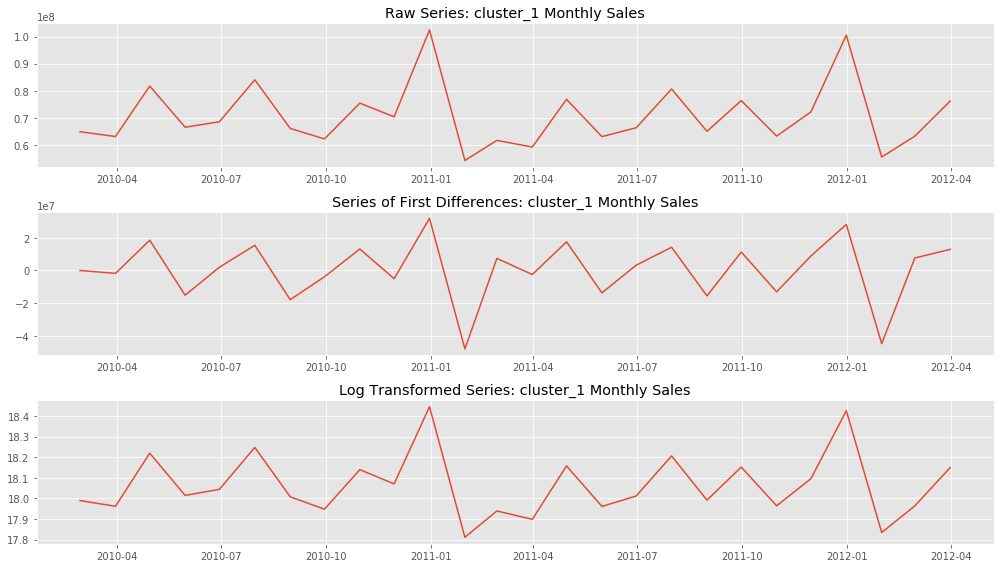

In [748]:
fig, axs = plt.subplots(3, figsize=(14, 8))
plot_series_and_difference(axs, train_monthly, 'cluster_1 Monthly Sales')
fig.tight_layout()

## Augmented Dickey-Fuller Test

In [749]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(train_monthly['cluster_1'].to_numpy(), regression='ct')

In [750]:
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -6.386523959750034
p-value: 3.267858023798294e-07


Time series for montly consolidation appears to be stationary, based on the ADF Test.

## ACF and PACF Plots

### Auto-Correlation Function (ACF) Plot

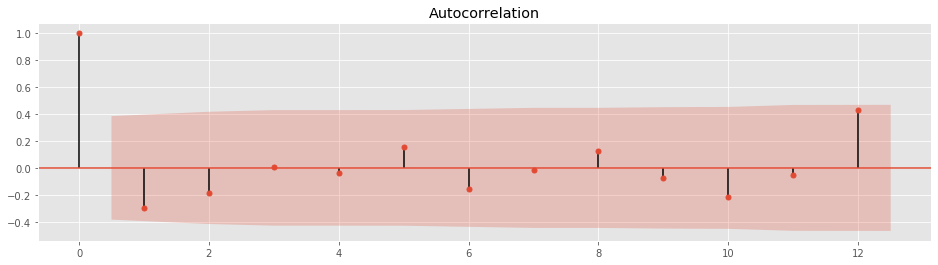

In [751]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(train_monthly, lags=12, ax=ax)

### Partial Auto-Correlation Function (PACF) Plot

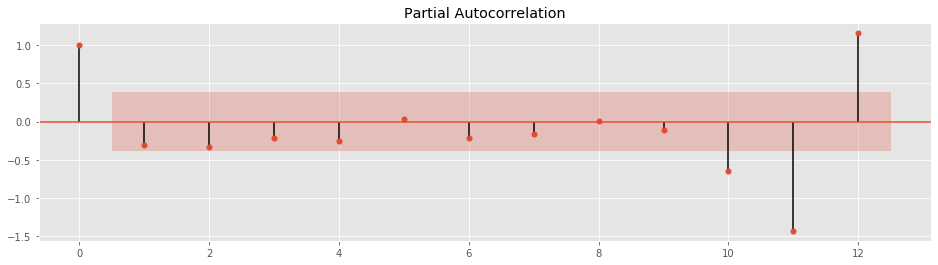

In [752]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(train_monthly, lags=12, ax=ax)

Monthly seasonality is causing spike in partial auto-correlation near the end of a full calendar year.

## Grid Search Model Parameters

In [753]:
## Dictionary to store models' performance metrics
scores2 = {'model_params': [], 'aic': [], 'maep_1_mth': [], 'maep_3_mths': [], 'maep_5_mths': [], 'maep_full': []}

for param in pdq:
    for s_param in seasonal_pdq:
        
        ## Fit SARIMAX model to training data (log transformed)
        try:
            model = SARIMAX(np.log(train_monthly), order=param, 
                            seasonal_order=s_param, exog=train_holiday_months).fit()
        except:
            continue
        
        ## Four sets of predictions (for different time intervals)
        preds1 = np.exp(model.predict(start=test_monthly.index[0], end=test_monthly.index[0], 
                                      exog=test_holiday_months[0:1],
                                      dynamic=True, plot_insample=False))
        preds2 = np.exp(model.predict(start=test_monthly.index[0], end=test_monthly.index[3], 
                                      exog=test_holiday_months[0:4],
                                      dynamic=True, plot_insample=False))
        preds3 = np.exp(model.predict(start=test_monthly.index[0], end=test_monthly.index[5], 
                                      exog=test_holiday_months[0:6],
                                      dynamic=True, plot_insample=False))
        preds4 = np.exp(model.predict(start=test_monthly.index[0], end=test_monthly.index[-1], 
                                      exog=test_holiday_months,
                                      dynamic=True, plot_insample=False))
        
        maep1 = np.mean(abs(test_monthly['cluster_1'][0] - preds1)) / np.mean(test_monthly['cluster_1'][0])
        maep2 = np.mean(abs(test_monthly['cluster_1'][0:4] - preds2)) / np.mean(test_monthly['cluster_1'][0:4])
        maep3 = np.mean(abs(test_monthly['cluster_1'][0:6] - preds3)) / np.mean(test_monthly['cluster_1'][0:6]) 
        maep4 = np.mean(abs(test_monthly['cluster_1'] - preds4)) / np.mean(test_monthly['cluster_1'])
        
        scores2['model_params'].append((param, s_param))
        scores2['aic'].append(model.aic)
        scores2['maep_1_mth'].append(maep1)
        scores2['maep_3_mths'].append(maep2)
        scores2['maep_5_mths'].append(maep3)
        scores2['maep_full'].append(maep4)
    

In [754]:
scores2_df = pd.DataFrame(scores2)
scores2_df.sort_values(by='maep_full', ascending=True, inplace=True)
scores2_df

model_params         aic  maep_1_mth  maep_3_mths  \
17  ((2, 1, 0), (0, 0, 0, 52))   -5.832817    0.050227     0.085696   
13  ((1, 1, 2), (0, 0, 0, 52))   -9.812291    0.074233     0.091846   
12  ((1, 1, 1), (0, 0, 0, 52))  -13.130707    0.045267     0.092959   
18  ((2, 1, 1), (0, 0, 0, 52))  -13.606158    0.082946     0.090203   
7   ((0, 1, 2), (0, 0, 0, 52))  -15.056939    0.067754     0.097191   
9   ((1, 0, 1), (0, 0, 0, 52))   -2.937675    0.066741     0.094600   
6   ((0, 1, 1), (0, 0, 0, 52))  -13.784418    0.066956     0.094699   
19  ((2, 1, 2), (0, 0, 0, 52))  -12.391907    0.107249     0.103920   
14  ((2, 0, 0), (0, 0, 0, 52))    9.167691    0.048756     0.105974   
11  ((1, 1, 0), (0, 0, 0, 52))   -1.450172    0.049679     0.106635   
5   ((0, 1, 0), (0, 1, 0, 52))    4.000000    0.194886     0.153244   
15  ((2, 0, 1), (0, 0, 0, 52))   17.036644    0.248383     0.151997   
8   ((1, 0, 0), (0, 0, 0, 52))   13.770141    0.192996     0.151517   
4   ((0, 1, 0), (0, 0, 0, 52))    3.151331    0.194886     0.153244   
16  ((2, 0, 2), (0, 0, 0, 52))   31.781013    0.505112     0.796772   
0   ((0, 0, 0), (0, 0, 0, 52))  217.145218    1.000000     1.000000   
3   ((0, 0, 2), (0, 0, 0, 52))  171.148172    0.994411     0.998721   
2   ((0, 0, 1), (0, 0, 0, 52))  196.574801    0.999608     0.999910   
1   ((0, 0, 0), (0, 1, 0, 52))    4.000000    1.000000     1.000000   
10  ((1, 0, 2), (0, 0, 0, 52))   33.529128    0.831905     1.374624   

    maep_5_mths  maep_full  
17     0.120695   0.105034  
13     0.116377   0.110054  
12     0.116934   0.110320  
18     0.117374   0.110833  
7      0.118551   0.112317  
9      0.120517   0.112678  
6      0.120576   0.112758  
19     0.124110   0.116751  
14     0.128512   0.122746  
11     0.129052   0.123784  
5      0.146072   0.151611  
15     0.158446   0.167755  
8      0.166780   0.167881  
4      0.168382   0.170992  
16     0.795697   0.818287  
0      0.875660   0.891986  
3      0.999160   0.999270  
2      0.999941   0.999949  
1      1.000000   1.000000  
10     1.410927   1.443514

Not enough data when consolidated to monthly, to account for seasonal lag auto-correlation. Results of monthly series are very poor compared to weekly time series.

# Cluster_2 Model (Weekly)

## Import Data

In [755]:
train2 = pd.read_pickle(train_pickle).iloc[:, 1:2]
test2 = pd.read_pickle(test_pickle).iloc[:, 1:2]

## Stationarity

In [802]:
fig = go.Figure()
## Actual Sales
fig.add_trace(go.Scatter(x=train2.index, y=train2['cluster_2'],
    fill=None,
    name='Actuals',
    mode='lines',
    line_color='green',
    ))
## Update plot features
fig.update_layout(
    autosize=False,
    xaxis=go.layout.XAxis(title_text='Time Series'), 
    yaxis=go.layout.YAxis(title_text='Sales ($)'))

fig.show()

In [804]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(train2['cluster_2'].to_numpy(), regression='ct')

In [805]:
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -4.959664961051613
p-value: 0.0002435106422602173


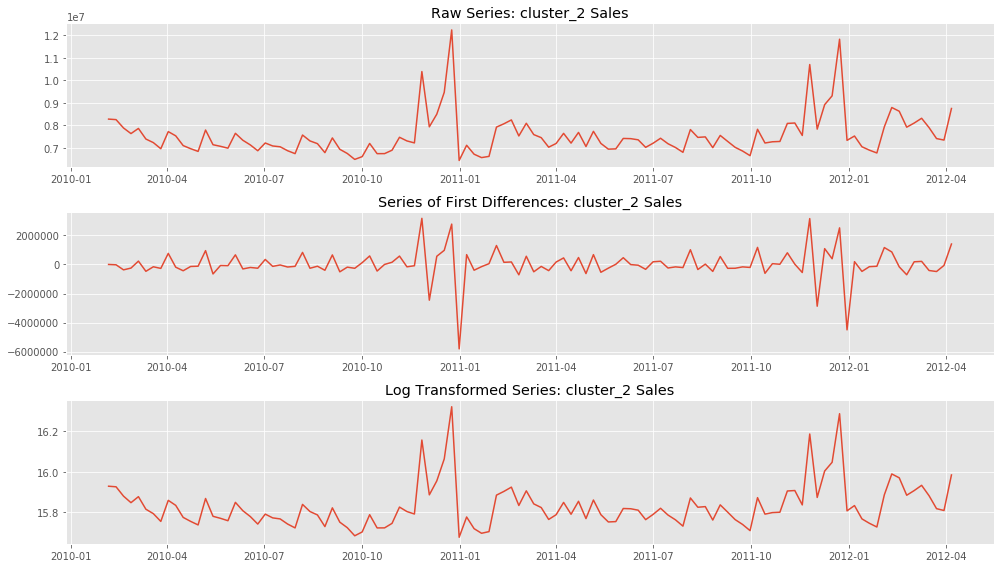

In [756]:
fig, axs = plt.subplots(3, figsize=(14, 8))
plot_series_and_difference(axs, train2, 'cluster_2 Sales')
fig.tight_layout()

## ACT and PACF Plots

### Auto-Correlation Function (ACF) Plot

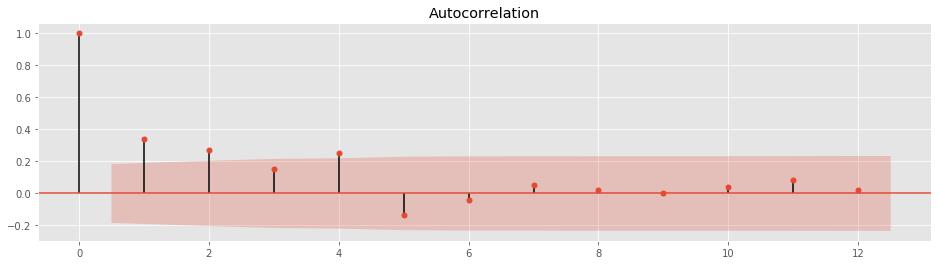

In [781]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(train2, lags=12, ax=ax)

### Partial Auto-Correlation Function (PACF) Plot

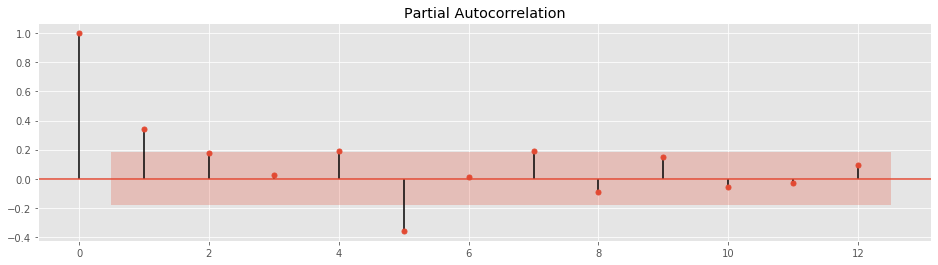

In [807]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(train2, lags=12, ax=ax)

## Grid Search Model Parameters

In [757]:
## Dictionary to store models' performance metrics
scores2 = {'model_params': [], 'aic': [], 'maep_1_week': [], 'maep_1_month': [], 'maep_3_months': [], 'maep_full': []}

for param in pdq:
    for s_param in seasonal_pdq:
        
        ## Fit SARIMAX model to training data (log transformed)
        try:
            model = SARIMAX(np.log(train2), order=param, 
                            seasonal_order=s_param, exog=train_holiday).fit()
        except:
            continue
        
        ## Four sets of predictions (for different time intervals)
        preds1 = np.exp(model.predict(start=test2.index[0], end=test2.index[0], 
                                      exog=test_holiday[0:1],
                                      dynamic=True, plot_insample=False))
        preds2 = np.exp(model.predict(start=test2.index[0], end=test2.index[3], 
                                      exog=test_holiday[0:4],
                                      dynamic=True, plot_insample=False))
        preds3 = np.exp(model.predict(start=test2.index[0], end=test2.index[11], 
                                      exog=test_holiday[0:12],
                                      dynamic=True, plot_insample=False))
        preds4 = np.exp(model.predict(start=test2.index[0], end=test2.index[-1], 
                                      exog=test_holiday,
                                      dynamic=True, plot_insample=False))
        
        maep1 = np.mean(abs(test2['cluster_2'][0] - preds1)) / np.mean(test2['cluster_2'][0])
        maep2 = np.mean(abs(test2['cluster_2'][0:4] - preds2)) / np.mean(test2['cluster_2'][0:4])
        maep3 = np.mean(abs(test2['cluster_2'][0:12] - preds3)) / np.mean(test2['cluster_2'][0:12]) 
        maep4 = np.mean(abs(test2['cluster_2'] - preds4)) / np.mean(test2['cluster_2'])
        
        scores2['model_params'].append((param, s_param))
        scores2['aic'].append(model.aic)
        scores2['maep_1_week'].append(maep1)
        scores2['maep_1_month'].append(maep2)
        scores2['maep_3_months'].append(maep3)
        scores2['maep_full'].append(maep4)
    

In [758]:
scores2_df = pd.DataFrame(scores2)
scores2_df.sort_values(by='maep_full', ascending=True, inplace=True)
scores2_df.head()

model_params         aic  maep_1_week  maep_1_month  \
34  ((1, 0, 2), (1, 0, 0, 52)) -139.593331     0.044686      0.040521   
33  ((1, 0, 2), (0, 1, 0, 52)) -219.561532     0.027933      0.049601   
53  ((2, 0, 1), (0, 1, 0, 52)) -219.570953     0.028238      0.049674   
29  ((1, 0, 1), (0, 1, 0, 52)) -221.507523     0.030888      0.050471   
35  ((1, 0, 2), (1, 1, 0, 52)) -217.730150     0.025291      0.054995   

    maep_3_months  maep_full  
34       0.032455   0.028708  
33       0.033552   0.031249  
53       0.033615   0.031490  
29       0.033874   0.031608  
35       0.035143   0.031613

In [759]:
clust2_params_1 = scores2_df['model_params'][34]
clust2_params_2 = scores2_df['model_params'][33]

clust2_model_1 = SARIMAX(np.log(train2), order=clust2_params_1[0], 
                         seasonal_order=clust2_params_1[1], exog=train_holiday).fit()

clust2_model_2 = SARIMAX(np.log(train2), order=clust2_params_2[0], 
                         seasonal_order=clust2_params_2[1], exog=train_holiday).fit()

## Make Predictions

### Predictions w/ Confidence Interval

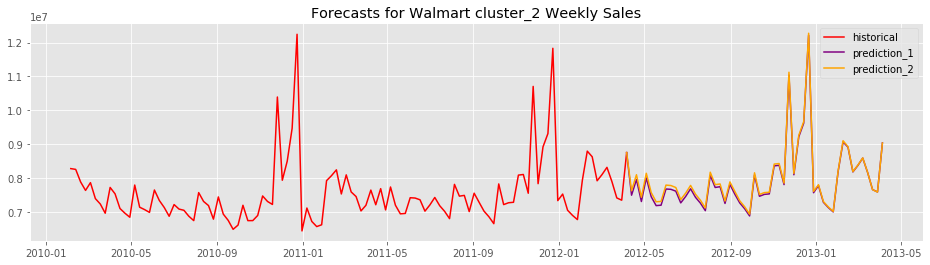

In [760]:
## Plot training data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(train2.index, train2, label='historical', color='red')

## Determine the number of future predictions to make
steps = 51

## Plot predictions (on test2 data)
preds1 = np.exp(clust2_model_1.predict(start=test2.index[0], end=test2.index[0] + steps, 
                                       exog=test_plus_future_holidays[:steps+1], 
                                       dynamic=True, ax=ax, plot_insample=False))

preds2 = np.exp(clust2_model_2.predict(start=test2.index[0], end=test2.index[0] + steps, 
                                       exog=test_plus_future_holidays[:steps+1], 
                                       dynamic=True, ax=ax, plot_insample=False))

ax.plot(preds1.index.insert(0, train2.index[-1]), 
        np.insert(preds1.values, 0, train2['cluster_2'][-1]), label='prediction_1', color='purple')

ax.plot(preds2.index.insert(0, train2.index[-1]), 
        np.insert(preds2.values, 0, train2['cluster_2'][-1]), label='prediction_2', color='orange')

## Plot 95% confidence interval for predictions
# pred_ci = np.exp(clust2_model_1.get_forecast(steps=steps+1, exog=test_plus_future_holidays[:steps+1])\
#                                 .conf_int(alpha=0.05))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title("Forecasts for Walmart cluster_2 Weekly Sales")
ax.legend();

Both models for cluster 2 are very similar, however prediction_1 is most accurate in the long term (7 months), whereas prediction_2 is most accruate in the short-term (3 months or less).  

After 7 months, both models are practically the same in terms of prediction values.


### Predictions vs. Results

#### Cluster 2 - Model #1

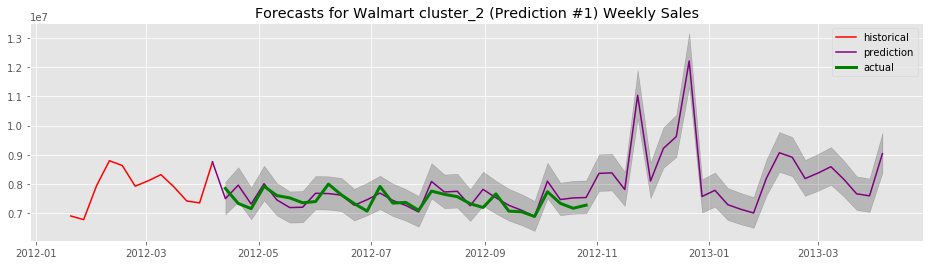

In [808]:
## Plot training data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(train2.index[102:], train2[102:], label='historical', color='red')

## Determine the number of future predictions to make
steps = 51

## Plot predictions (on test data)
preds1 = np.exp(clust2_model_1.predict(start=test2.index[0], end=test2.index[0] + steps, 
                                       exog=test_plus_future_holidays[:steps+1], 
                                       dynamic=True, ax=ax, plot_insample=False))

ax.plot(preds1.index.insert(0, train2.index[-1]), 
        np.insert(preds1.values, 0, train2['cluster_2'][-1]), label='prediction', color='purple')

## Plot 95% confidence interval for predictions
pred_ci = np.exp(clust2_model_1.get_forecast(steps=steps+1, exog=test_plus_future_holidays[:steps+1])\
                                .conf_int(alpha=0.05))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.plot(test2.index, test2, label='actual', linestyle='-', lw=3.0, color='green')
ax.set_title("Forecasts for Walmart cluster_2 (Prediction #1) Weekly Sales")
ax.legend();

In [829]:
fig = go.Figure()
## Actual Sales
fig.add_trace(go.Scatter(x=train2.index[102:], y=train2[102:]['cluster_2'],
    fill=None,
    name='Historical',
    mode='lines',
    line_color='green',
    ))
## Lower Confidence Interval Limit
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 0],
    fill=None,
    mode='lines',
    showlegend=False,
    opacity=0.5,
    line_color='#DED2FD',
    ))
## Upper Confidence Interval Limit
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 1],
    fill='tonexty', # fill area between trace1 and trace2
    mode='lines', 
    showlegend=False,
    opacity=0.5,
    fillcolor='#F0EBFC',
    line_color='#DED2FD'))
fig.add_trace(go.Scatter(x=preds1.index.insert(0, train2.index[-1]), 
                         y=np.insert(preds1.values, 0, train2['cluster_2'][-1]),
    fill=None,
    name='Forecast',
    mode='lines',
    line_color='purple',
    ))
fig.add_trace(go.Scatter(x=test2.index, 
                         y=test2['cluster_2'],
    fill=None,
    name='Test Actual',
    mode='lines',
    line_color='red',
    ))
## Update plot features
fig.update_layout(
    autosize=False,
    xaxis=go.layout.XAxis(title_text='Time Series'), 
    yaxis=go.layout.YAxis(title_text='Sales ($)'))
fig.show()

#### Cluster 2 - Model #2

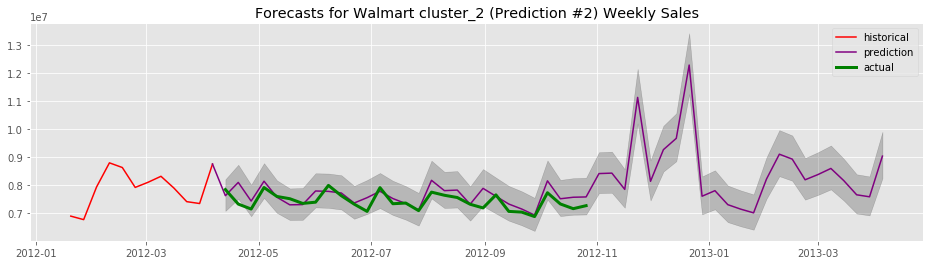

In [762]:
## Plot training data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(train2.index[102:], train2[102:], label='historical', color='red')

## Determine the number of future predictions to make
steps = 51

## Plot predictions (on test data)
pred2 = np.exp(clust2_model_2.predict(start=test2.index[0], end=test2.index[0] + steps, 
                                       exog=test_plus_future_holidays[:steps+1], 
                                       dynamic=True, ax=ax, plot_insample=False))

ax.plot(pred2.index.insert(0, train2.index[-1]), 
        np.insert(pred2.values, 0, train2['cluster_2'][-1]), label='prediction', color='purple')

## Plot 95% confidence interval for predictions
pred_ci = np.exp(clust2_model_2.get_forecast(steps=steps+1, exog=test_plus_future_holidays[:steps+1])\
                                .conf_int(alpha=0.05))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.plot(test2.index, test2, label='actual', linestyle='-', lw=3.0, color='green')
ax.set_title("Forecasts for Walmart cluster_2 (Prediction #2) Weekly Sales")
ax.legend();

# Pickled Data

## Holiday Mapping

In [796]:
## Train Holidays
output = open('train_holidays.pkl', 'wb')
pickle.dump(train_holiday, output)
output.close()

## Test Holidays
output = open('test_holidays.pkl', 'wb')
pickle.dump(test_holiday, output)
output.close()

## Future Holidays
output = open('test_plus_future_holidays.pkl', 'wb')
pickle.dump(test_plus_future_holidays, output)
output.close()


## Cluster 1:

### Data Frames

In [794]:
output = open('cluster_1_train.pkl', 'wb')
pickle.dump(train, output)
output.close()

In [795]:
output = open('cluster_1_test.pkl', 'wb')
pickle.dump(test, output)
output.close()

### SARIMAX Model

In [788]:
output = open('cluster_1_sarimax.pkl', 'wb')
pickle.dump(best_model_exog, output)
output.close()

## Cluster 2 :

### Data Frames

In [797]:
output = open('cluster_2_train.pkl', 'wb')
pickle.dump(train2, output)
output.close()

In [798]:
output = open('cluster_2_test.pkl', 'wb')
pickle.dump(test2, output)
output.close()

### SARIMAX Models

#### Model #1

In [789]:
output = open('cluster_2_sarimax_1.pkl', 'wb')
pickle.dump(clust2_model_1, output)
output.close()

#### Model #2

In [790]:
output = open('cluster_2_sarimax_2.pkl', 'wb')
pickle.dump(clust2_model_2, output)
output.close()